In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as scop

import peptides
import propy

import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pkl
import os
import time

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit

from sklearn.feature_selection import mutual_info_regression


In [2]:
SAVE_FIGURES = False
SAVE_FILES   = False

In [3]:
os.getcwd()

'/media/jmenard/Data/projects/compare-latent-spaces-amps/oracles'

In [4]:
from mic_svr import compute_propy_properties, VS_SSVR, perform_mRMR

In [5]:
# gets training and testing data, as used by Witten & Witten (2019). 
data_dir = "Antimicrobial-Peptides/models/Saved_variables/"
ecoli_train_with_c = pd.read_pickle(f'{data_dir}ecoli_train_with_c_df.pkl')
ecoli_train_no_c = pd.read_pickle(f'{data_dir}ecoli_train_no_c_df.pkl')

ecoli_test = pd.read_pickle(f'{data_dir}ecoli_test_df.pkl')

ecoli_df = pd.read_pickle(f'{data_dir}ecoli_all_df.pkl')
ecoli_df_no_c = pd.read_pickle(f'{data_dir}ecoli_all_no_c_df.pkl')

all_df = pd.read_pickle(f'{data_dir}all_df.pkl')

ecoli_train_train_no_c = pd.read_pickle(f'{data_dir}ecoli_train_train_no_c_df.pkl')
ecoli_validate_no_c = pd.read_pickle(f'{data_dir}ecoli_validate_no_c_df.pkl')

In [6]:
# train_X = ecoli_train_physico_props[ecoli_train_physico_props.columns[1:]] # ignore col=='sequence'
train_X = ecoli_train_with_c.sequence
train_Y = ecoli_train_with_c.value

# test_X = ecoli_test_physico_props[ecoli_test_physico_props.columns[1:]] # ignore col=='sequence'
test_X = ecoli_test.sequence
test_Y = ecoli_test.value

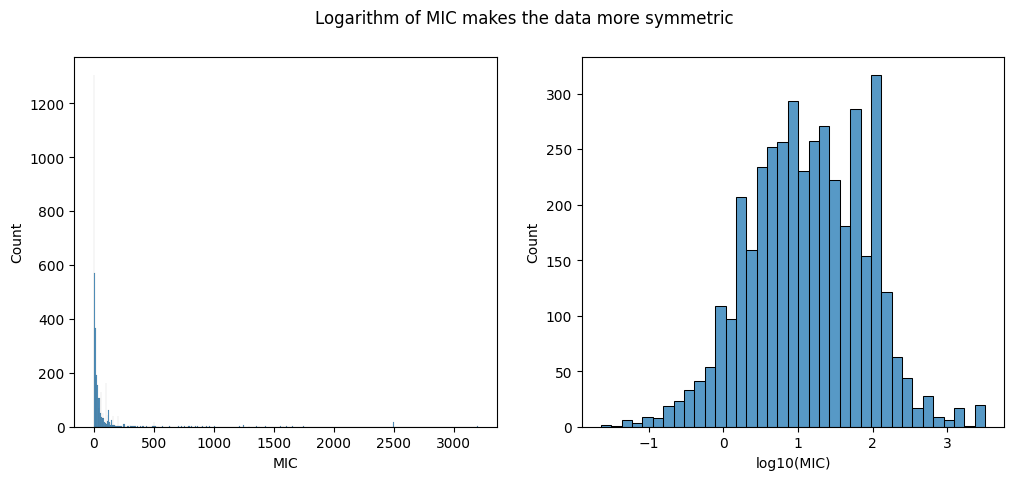

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(12)
sns.histplot(10**train_Y, ax=axes[0])
sns.histplot(train_Y, ax=axes[1])
axes[0].set_xlabel("MIC")
axes[1].set_xlabel("log10(MIC)")
fig.suptitle("Logarithm of MIC makes the data more symmetric")

if SAVE_FIGURES:
    fig.savefig("../figures/train_MIC_compare_log10.png",dpi=200)

In [8]:
train_Y[:5]

0    2.099950
1    1.000000
2    1.903090
3    0.250463
4    1.108874
Name: value, dtype: float64

In [9]:
distances=[]
N = 100
for i in range(100):
    for j in range(i, 100):
        mici = train_Y[i]
        micj = train_Y[j]
        distances.append( (mici-micj)**2 )
print(np.mean(distances))

KeyError: 31

In [9]:
min([len(x) for x in list(train_X)])

2

In [10]:
if not SAVE_FILES:
    propy_des = pd.read_csv("train_propy_des.csv")
else:
    propy_des = compute_propy_properties( list(train_X) )

In [11]:
propy_des.head()

,sequence,A,R,N,D,C,E,Q,G,H,...,QSOgrant41,QSOgrant42,QSOgrant43,QSOgrant44,QSOgrant45,QSOgrant46,QSOgrant47,QSOgrant48,QSOgrant49,QSOgrant50
0,AAAAAAAAAAGIGKFLHSAKKFGKAFVGEIMNS,36.364,0.000,3.030,0.000,0.0,3.030,0.0,12.121,3.03,...,0.022700,0.017385,0.018068,0.015566,0.015566,0.012724,0.011812,0.011011,0.008462,0.006495
1,AAAAAAAIKMLMDLVNERIMALNKKAKK,32.143,3.571,7.143,3.571,0.0,3.571,0.0,0.000,0.00,...,0.020452,0.017617,0.013826,0.010370,0.006913,0.006913,0.003457,0.000000,0.000000,0.000000
2,AAAKAALNAVLVGANA,50.000,0.000,12.500,0.000,0.0,0.000,0.0,6.250,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,10.000,7.500,5.000,5.000,15.0,2.500,0.0,10.000,5.00,...,0.019008,0.026733,0.023929,0.021680,0.021471,0.022561,0.021130,0.012482,0.012787,0.012900
4,AAGMGFFGAR,30.000,10.000,0.000,0.000,0.0,0.000,0.0,30.000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
if SAVE_FILES:
    propy_des.to_csv("train_propy_des.csv",index=False) 

In [13]:
seq_len = propy_des.sequence.str.len()
print(f"min len = {min(seq_len)}, max len = {max(seq_len)}")
nlt5 = sum(seq_len<5)
ngt100=sum(seq_len>100)
print(f"n<5 = {nlt5}, n>100 = {ngt100}")
print(f"{len(seq_len)=}, {len(seq_len)-nlt5-ngt100=}")

min len = 2, max len = 190
n<5 = 16, n>100 = 18
len(seq_len)=4050, len(seq_len)-nlt5-ngt100=4016


In [14]:
seq_len = test_X.str.len()
print(f"min len = {min(seq_len)}, max len = {max(seq_len)}")
nlt5 = sum(seq_len<5)
ngt100=sum(seq_len>100)
print(f"n<5 = {nlt5}, n>100 = {ngt100}")
print(f"{len(seq_len)=}, {len(seq_len)-nlt5-ngt100=}")

min len = 2, max len = 72
n<5 = 5, n>100 = 0
len(seq_len)=509, len(seq_len)-nlt5-ngt100=504


In [15]:
vs_ssvr = VS_SSVR()

Hyperparameters (re)set. Must re-reun variable selection.


In [16]:
type(train_Y.values)

numpy.ndarray

In [17]:
print(f"{propy_des.shape=}")
input_data = propy_des.dropna()
print(f"{input_data.shape=}")
print(f"{train_Y.shape=}")
train_Y = train_Y[(propy_des.isna().sum(axis=1)==0).values]
print(f"{train_Y.shape=}")

print(f"{train_Y.shape=}")
train_Y = train_Y.loc[
    ((input_data.sequence.str.len()>4) &
    (input_data.sequence.str.len()<101)).values
]
print(f"{train_Y.shape=}")

input_data = input_data.loc[
    (input_data.sequence.str.len()>4) &
    (input_data.sequence.str.len()<101)
]
print(f"{input_data.shape=}")
input_data = input_data.loc[:,input_data.columns[1:]]
print(f"{input_data.shape=}")

propy_des.shape=(4050, 1530)
input_data.shape=(4033, 1530)
train_Y.shape=(4050,)
train_Y.shape=(4033,)
train_Y.shape=(4033,)
train_Y.shape=(4015,)
input_data.shape=(4015, 1530)
input_data.shape=(4015, 1529)


In [18]:
t0 = time.time()
tst_ = mutual_info_regression(input_data.iloc[:,1:], input_data.iloc[:,2])
print(f"{time.time()-t0}s")

KeyboardInterrupt: 

In [ ]:
for i in range(2,6,1):
    print(f"{i=}")
    t0 = time.time()
    tst_ = perform_mRMR(input_data, train_Y, max_features=i, verbose=True)
    print(f"{time.time()-t0}s")

In [20]:
tst_

{(1227,): {'incremental_relevance': 0.33499841941766384,
  'redundancy': 0.0,
  'mRMR_score': 0.33499841941766384},
 (1227, 1252): {'incremental_relevance': 0.31909743673495683,
  'redundancy': 0.0,
  'mRMR_score': nan},
 (1227, 1252, 1272): {'incremental_relevance': 0.30955249173675803,
  'redundancy': 0.0,
  'mRMR_score': nan},
 (1227, 1252, 1272, 1222): {'incremental_relevance': 0.3079204323070135,
  'redundancy': 0.0,
  'mRMR_score': nan},
 (1227, 1252, 1272, 1222, 1277): {'incremental_relevance': 0.3046678415010504,
  'redundancy': 0.0,
  'mRMR_score': nan},
 (1227,
  1252,
  1272,
  1222,
  1277,
  1202): {'incremental_relevance': 0.3044972115925191, 'redundancy': 0.0, 'mRMR_score': nan}}

In [20]:
t0 = time.time()
tst_,_,_ = perform_mRMR(input_data, train_Y, max_features=10, verbose=True)
print(f"{time.time()-t0}s")

Computing relevancy for 10 features took 34.762 seconds
Computing pairwise redundancies for 10 features took 299.4526 seconds
mRMR incremental for 10 features took 0.0005 seconds
334.2156312465668s


In [21]:
tst_

{(1227,): {'incremental_relevance': 0.33499841941766384,
  'redundancy': 0.0,
  'incremental_mRMR_score': 0.33499841941766384},
 (1227, 5): {'incremental_relevance': 0.07572904083066634,
  'redundancy': 0.4355490454260824,
  'incremental_mRMR_score': -0.3598200045954161},
 (1227, 5, 8): {'incremental_relevance': 0.10119147987869592,
  'redundancy': 0.3609241306221178,
  'incremental_mRMR_score': -0.2597326507434219},
 (1227, 5, 8, 4): {'incremental_relevance': 0.12346992024321146,
  'redundancy': 0.35109986642047275,
  'incremental_mRMR_score': -0.2276299461772613},
 (1227, 5, 8, 4, 6): {'incremental_relevance': 0.0709769903035995,
  'redundancy': 0.324290776906756,
  'incremental_mRMR_score': -0.2533137866031565},
 (1227, 5, 8, 4, 6, 3): {'incremental_relevance': 0.07247989174374547,
  'redundancy': 0.31347526932240105,
  'incremental_mRMR_score': -0.24099537757865558},
 (1227, 5, 8, 4, 6, 3, 1): {'incremental_relevance': 0.17832665069759113,
  'redundancy': 0.42640400989194976,
  'in

In [19]:
tst_

{(1227,): {'incremental_relevance': 0.33499841941766384,
  'redundancy': 0.0,
  'incremental_mRMR_score': 0.33499841941766384},
 (1227, 5): {'incremental_relevance': 0.07572904083066634,
  'redundancy': 0.4355490454260824,
  'incremental_mRMR_score': -0.3598200045954161},
 (1227, 5, 3): {'incremental_relevance': 0.07247989174374547,
  'redundancy': 0.36691090863321385,
  'incremental_mRMR_score': -0.2944310168894684},
 (1227, 5, 3, 6): {'incremental_relevance': 0.0709769903035995,
  'redundancy': 0.33610391399611367,
  'incremental_mRMR_score': -0.26512692369251417},
 (1227, 5, 3, 6, 4): {'incremental_relevance': 0.12346992024321146,
  'redundancy': 0.3630130683296642,
  'incremental_mRMR_score': -0.23954314808645272},
 (1227, 5, 3, 6, 4, 1): {'incremental_relevance': 0.17832665069759113,
  'redundancy': 0.44434562467352556,
  'incremental_mRMR_score': -0.26601897397593444},
 (1227, 5, 3, 6, 4, 1, 2): {'incremental_relevance': 0.12091181066736567,
  'redundancy': 0.4585754128050274,
  

Text(0.5, 1.0, 'time to compute redundancy')

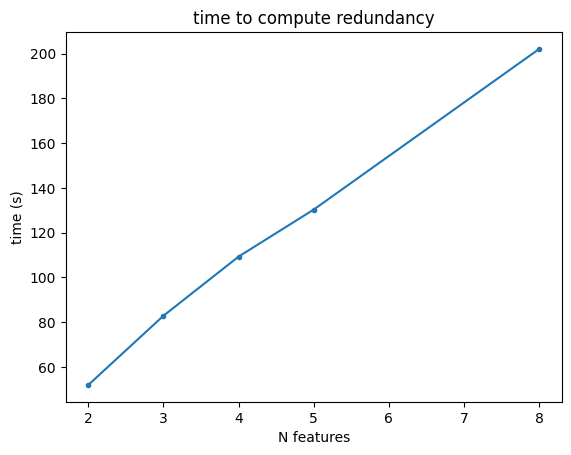

In [27]:
xvals = [2,3,4,5,8]
yvals = [51.96, 82.88, 109.32, 130.35,202.14]
plt.plot(xvals,yvals,marker=".")
plt.xlabel("N features")
plt.ylabel("time (s)")
plt.title("time to compute redundancy")

In [24]:
m = (202.14- 109.32)/(8-4)
b =  51.96- m*2
print(f"{m=}, {b=}")
print(f"estimated time for all 1530 features = {m*1530+b}s, which is {(m*1530+b)/3600}hrs")

m=23.205, b=5.550000000000004
estimated time for all 1530 features = 35509.2s, which is 9.863666666666665hrs


In [20]:
tst_

{(1227,): {'incremental_relevance': 0.33499841941766384,
  'redundancy': 0.0,
  'mRMR_score': 0.33499841941766384},
 (1227, 1252): {'incremental_relevance': 0.31909743673495683,
  'redundancy': 0.0,
  'mRMR_score': nan},
 (1227, 1252, 1272): {'incremental_relevance': 0.30955249173675803,
  'redundancy': 0.0,
  'mRMR_score': nan},
 (1227, 1252, 1272, 1222): {'incremental_relevance': 0.3079204323070135,
  'redundancy': 0.0,
  'mRMR_score': nan},
 (1227, 1252, 1272, 1222, 1277): {'incremental_relevance': 0.3046678415010504,
  'redundancy': 0.0,
  'mRMR_score': nan}}

In [29]:
30*1500/3600

12.5

In [16]:
input_data.shape

(4015, 1529)

In [17]:
if SAVE_FILES:
    results = vs_ssvr.variable_selection_sparse_svr(input_data, train_Y, n_splits=10, max_iter=1000)
    with open("feature_selection_results.pkl","wb") as f:
        pkl.dump(results, f)
else:
    with open("feature_selection_results.pkl",'rb') as f:
        results = pkl.load(f)

In [18]:
results

{'split_0': {'best_params': {'alpha': 0.01},
  'best_mse': 0.5793481503643084,
  'coefficients': array([0., 0., 0., ..., 0., 0., 0.])},
 'split_1': {'best_params': {'alpha': 0.01},
  'best_mse': 0.5418232826950369,
  'coefficients': array([ 0.        , -0.        , -0.        , ..., -0.01724432,
          0.        , -0.        ])},
 'split_2': {'best_params': {'alpha': 0.01},
  'best_mse': 0.580112102976501,
  'coefficients': array([ 0.        , -0.        , -0.        , ..., -0.00060872,
         -0.        , -0.        ])},
 'split_3': {'best_params': {'alpha': 0.01},
  'best_mse': 0.5625513714426246,
  'coefficients': array([ 0.       , -0.       , -0.       , ..., -0.0073598, -0.       ,
          0.       ])},
 'split_4': {'best_params': {'alpha': 0.01},
  'best_mse': 0.6157464373880178,
  'coefficients': array([ 0.        , -0.        , -0.        , ..., -0.00027799,
         -0.        , -0.        ])},
 'split_5': {'best_params': {'alpha': 0.1},
  'best_mse': 0.624649647422211

In [19]:
results["indices_above_dummy_threshold"].shape

(196,)

In [20]:
results['split_0']['coefficients'][-12:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
sum(np.abs(results['split_0']['coefficients'])>1e-7)

196

In [22]:
important_features = results['split_0']['coefficients']
for i in range(1,5):
    important_features += results[f'split_{i}']['coefficients']
important_features /= 5

# set those <= dummy threshold to zero
indices_to_zero = set(list(range(len(important_features)))) - set(results['indices_above_dummy_threshold'])
for i in indices_to_zero:
    important_features[i]=0.0

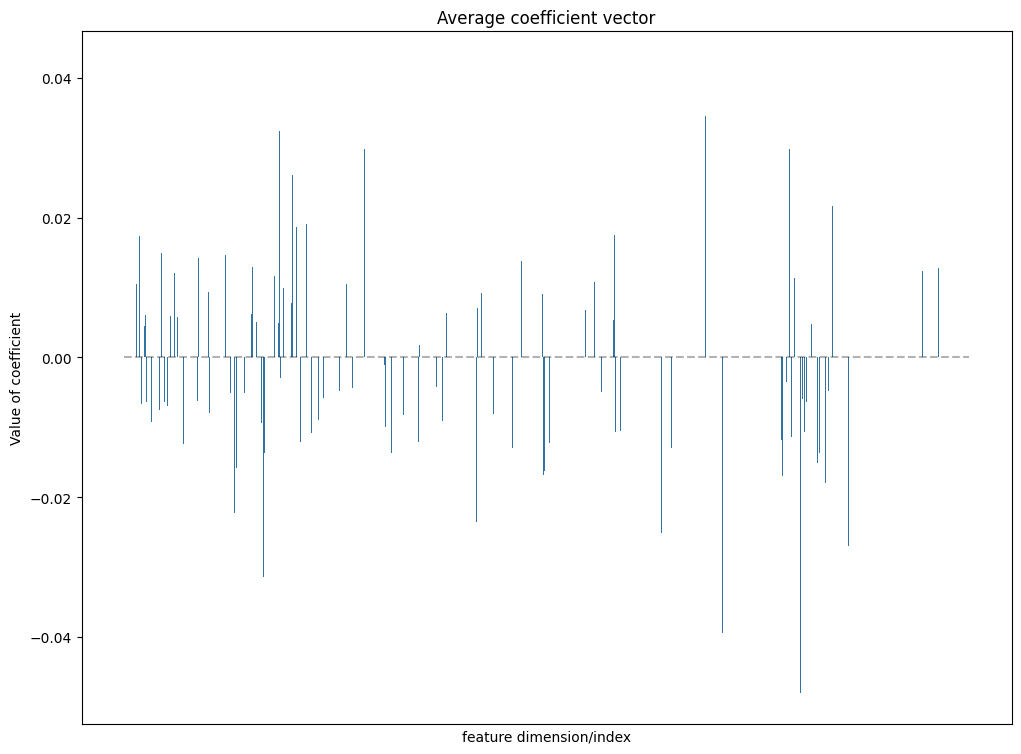

In [47]:
fig = plt.figure(figsize=(12,9))
sns.barplot(important_features)
plt.hlines(y=0, xmin=0, xmax=len(important_features), color="k", linestyle="--",alpha=0.3)
plt.xticks(ticks=[],labels=[])
plt.xlabel("feature dimension/index")
plt.ylabel("Value of coefficient")
plt.title("Average coefficient vector")

if SAVE_FIGURES:
    plt.savefig(f"../figures/final_coefficient_vector_from_lasso.png",dpi=200)

In [24]:
sum(np.abs(important_features)>0)

196

In [25]:
important_features[-11:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
sum(important_features>0.05)

0

In [27]:
sum(np.abs(important_features)>0)

196

## get intersecting non-zero features

In [28]:
intersecting_nonzero_features = None
for k, split_results in results.items():
    if "split" not in k:
        continue

    coefs_ = split_results['coefficients'].copy()

    dummy_feature_threshold_ = np.mean(np.abs(coefs_[-10:]))
    # set those <= dummy threshold to zero
    # indices_to_zero = set(list(range(len(coefs_)))) - set(results['indices_above_dummy_threshold'])
    nonzero_idxs_ = list(np.where(np.abs(coefs_)>dummy_feature_threshold)[0])
    if intersecting_nonzero_features is None:
        intersecting_nonzero_features = set( nonzero_idxs_ )
    else:
        intersecting_nonzero_features = intersecting_nonzero_features.intersection(nonzero_idxs_)
    print(intersecting_nonzero_features)

NameError: name 'dummy_feature_threshold' is not defined

In [29]:
len(intersecting_nonzero_features)

TypeError: object of type 'NoneType' has no len()

# nonlinear SVR model

In [30]:
input_data_important_features = input_data.iloc[:, list(results['indices_above_dummy_threshold'])]

In [31]:
len(np.arange(-3,2+0.1,0.5))

11

In [33]:
np.arange(-2,2+0.1,1)

array([-2., -1.,  0.,  1.,  2.])

In [34]:
def coarse_hyperparameter_sweep(X, y, n_splits=15):
    
    shuffler = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    logC_values   = np.arange(-2,2+0.1,1) # + 0.1 to ensure we get the endpoint
    logeps_values = np.arange(-2,2+0.1,1)
    C_values       = np.power(10,logC_values)
    epsilon_values = np.power(10,logeps_values)
    results = {
        'C_values':[],
        'epsilon_values':[],
        'mse_training':[],
        'mse_validation':[],
        "r2_training":[],
        "r2_validation":[],
        'best_params':{'C':None, 'epsilon':None},
        'best_mse':np.inf
    }
    tot = len(logC_values)*len(logeps_values)
    counter =0 
    for c_ in C_values:
        for epsilon_ in epsilon_values:
            counter+=1
            t0 = time.time()
            svr_ = SVR(kernel='rbf', 
                       C=c_,
                       epsilon=epsilon_)
    
            # average over splits
            avg_mse_validation_ = 0
            for i, (train_index, test_index) in enumerate(shuffler.split(X)):
                train_X_ = X.iloc[train_index]
                train_Y_ = y.iloc[train_index]
    
                test_X_ = X.iloc[test_index]
                test_Y_ = y.iloc[test_index]
    
                # center features
                scaler.fit(train_X_)
                train_X_ = scaler.transform(train_X_)
                test_X_  = scaler.transform(test_X_)
    
                # fit
                svr_.fit(train_X_, train_Y_)

                ##############
                # compute MSE
                ##############
                # training
                mse_training_ = mean_squared_error(
                    train_Y_,
                    svr_.predict(train_X_)
                )
                r2_training_ = svr_.score(train_X_, train_Y_)
                # validation
                mse_validation_ = mean_squared_error(
                    test_Y_,
                    svr_.predict(test_X_)
                )
                avg_mse_validation_+=mse_validation_
                
                r2_validation_ = svr_.score(test_X_, test_Y_)

                results[      'C_values'].append(c_)
                results['epsilon_values'].append(epsilon_)
                results['mse_training'  ].append(mse_training_)
                results['mse_validation'].append(mse_validation_)
                results['r2_training'  ].append(r2_training_)
                results['r2_validation'].append(r2_validation_)
            # average
            avg_mse_validation_ /= n_splits
            print(f"iter:{counter}/{tot}; time for c, eps = {c_},{epsilon_} is: {round(time.time()-t0,4)}")
            if avg_mse_validation_ < results['best_mse']:
                results['best_mse'] = avg_mse_validation_
                results['best_params']['C'] = c_
                results['best_params']['epsilon'] = epsilon_

    return results

def nonlinear_svr_mse(x0, X, y):
    c, epsilon = x0
    n_splits = 5
    shuffler = ShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    
    svr_ = SVR(kernel='rbf', 
               C=c,
               epsilon=epsilon
    )

    # average over splits
    mse_validation = 0
    for i, (train_index, test_index) in enumerate(shuffler.split(X)):
        train_X_ = X.iloc[train_index]
        train_Y_ = y.iloc[train_index]

        test_X_ = X.iloc[test_index]
        test_Y_ = y.iloc[test_index]

        # center features
        scaler.fit(train_X_)
        train_X_ = scaler.transform(train_X_)
        test_X_  = scaler.transform(test_X_)

        # fit
        svr_.fit(train_X_, train_Y_)

        # compute MSE
        mse_ = mean_squared_error(
            test_Y_,
            svr_.predict(test_X_)
        )
        mse_validation += mse_
    mse_validation /= n_splits
    return mse_validation

In [35]:
t0 = time.time()
initial_param_sweep_results = coarse_hyperparameter_sweep(input_data_important_features, train_Y, n_splits=10)
print(f"{round(time.time()-t0,4)}s")

with open("coarse_param_sweep_results.pkl",'wb') as f: 
    pkl.dump(initial_param_sweep_results,f)

iter:1/25; time for c, eps = 0.01,0.01 is: 52.9615
iter:2/25; time for c, eps = 0.01,0.1 is: 50.3113
iter:3/25; time for c, eps = 0.01,1.0 is: 9.9407
iter:4/25; time for c, eps = 0.01,10.0 is: 0.3272
iter:5/25; time for c, eps = 0.01,100.0 is: 0.2532
iter:6/25; time for c, eps = 0.1,0.01 is: 61.4264
iter:7/25; time for c, eps = 0.1,0.1 is: 48.5687
iter:8/25; time for c, eps = 0.1,1.0 is: 12.6826
iter:9/25; time for c, eps = 0.1,10.0 is: 0.2862
iter:10/25; time for c, eps = 0.1,100.0 is: 0.3396
iter:11/25; time for c, eps = 1.0,0.01 is: 73.4917
iter:12/25; time for c, eps = 1.0,0.1 is: 48.4615
iter:13/25; time for c, eps = 1.0,1.0 is: 6.3513
iter:14/25; time for c, eps = 1.0,10.0 is: 0.2185
iter:15/25; time for c, eps = 1.0,100.0 is: 0.2227
iter:16/25; time for c, eps = 10.0,0.01 is: 69.9909
iter:17/25; time for c, eps = 10.0,0.1 is: 52.9863
iter:18/25; time for c, eps = 10.0,1.0 is: 8.065
iter:19/25; time for c, eps = 10.0,10.0 is: 0.2243
iter:20/25; time for c, eps = 10.0,100.0 is: 0.

In [39]:
initial_param_sweep_results.keys()
initial_param_sweep_df = pd.DataFrame(
    {      'C_values':initial_param_sweep_results['C_values'],
     'epsilon_values':initial_param_sweep_results['epsilon_values'],
       'mse_training':initial_param_sweep_results['mse_training'],
     'mse_validation':initial_param_sweep_results['mse_validation'],
       'r2_training':initial_param_sweep_results['r2_training'],
     'r2_validation':initial_param_sweep_results['r2_validation']
    }
)

In [40]:
initial_param_sweep_df.head()

,C_values,epsilon_values,mse_training,mse_validation,r2_training,r2_validation
0,0.01,0.01,0.523756,0.511333,0.114257,0.112021
1,0.01,0.01,0.515365,0.541742,0.120575,0.090230
2,0.01,0.01,0.518038,0.525214,0.120021,0.102439
3,0.01,0.01,0.509282,0.574832,0.113258,0.106218
4,0.01,0.01,0.516093,0.532315,0.121537,0.100090


In [41]:
initial_param_sweep_results["best_params"]

{'C': 10.0, 'epsilon': 0.1}

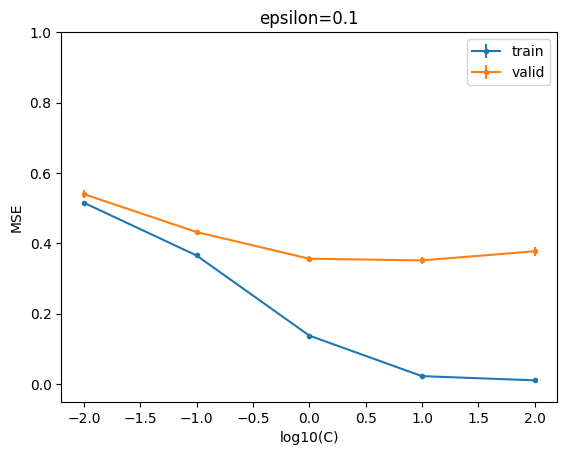

In [46]:
fixed_epsilon = 1e-1
data2plot_train = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon,"mse_training"]
data2plot_valid = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon,"mse_validation"]

grouped_by_cvalue_mn  = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon].groupby("C_values").mean()
grouped_by_cvalue_mn.reset_index(inplace=True)
grouped_by_cvalue_std = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon].groupby("C_values").std()


plt.errorbar(
    np.log10(grouped_by_cvalue_mn["C_values"]),
    grouped_by_cvalue_mn["mse_training"],
    yerr=1.96*grouped_by_cvalue_std["mse_training"]/np.sqrt(10),
    label="train",
    marker="."
)
plt.errorbar(
    np.log10(grouped_by_cvalue_mn["C_values"]),
    grouped_by_cvalue_mn["mse_validation"],
    yerr=1.96*grouped_by_cvalue_std["mse_validation"]/np.sqrt(10),
    label="valid",
    marker="."
)
plt.legend()
plt.title(f"epsilon={fixed_epsilon}")
plt.ylabel("MSE")
plt.xlabel("log10(C)")
plt.ylim([-0.05,1.0])

if SAVE_FIGURES:
    plt.savefig(f"../figures/validation_curve_mic_svr_epsilonEq{fixed_epsilon}_Csweep.png",dpi=200)

In [44]:
os.getcwd()

'/media/jmenard/Data/projects/compare-latent-spaces-amps/oracles'

(-0.05, 1.0)

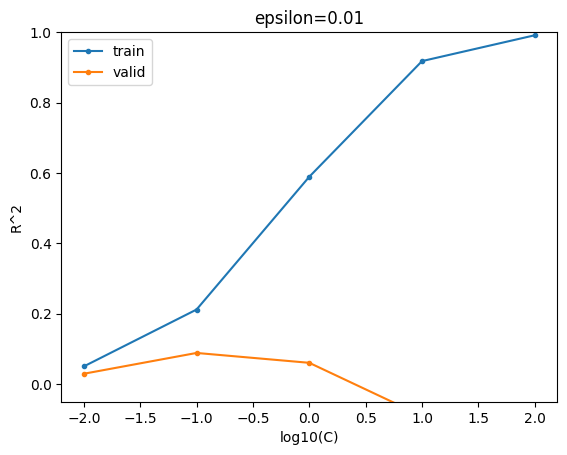

In [103]:
fixed_epsilon = 1e-2
data2plot_train = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon,"mse_training"]
data2plot_valid = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon,"mse_validation"]

grouped_by_cvalue_mn  = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon].groupby("C_values").mean()
grouped_by_cvalue_mn.reset_index(inplace=True)
grouped_by_cvalue_std = initial_param_sweep_df.loc[initial_param_sweep_df['epsilon_values']==fixed_epsilon].groupby("C_values").std()


plt.errorbar(
    np.log10(grouped_by_cvalue_mn["C_values"]),
    grouped_by_cvalue_mn["r2_training"],
    label="train",
    marker="."
)
plt.errorbar(
    np.log10(grouped_by_cvalue_mn["C_values"]),
    grouped_by_cvalue_mn["r2_validation"],
    label="valid",
    marker="."
)
plt.legend()
plt.title(f"epsilon={fixed_epsilon}")
plt.ylabel("R^2")
plt.xlabel("log10(C)")
plt.ylim([-0.05,1.0])

In [104]:
############################
# baseline validation mse
# should be able to do better than this. 
shuffler = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
mse_validation = 0
for i, (train_index, test_index) in enumerate(shuffler.split(input_data_important_features)):
    train_y_ = train_Y.iloc[train_index]
    test_y_ = train_Y.iloc[test_index]
    mean_y = np.mean(train_y_)
    pred_y = mean_y*np.ones_like(test_y_)
    mse_ = mean_squared_error(test_y_, pred_y)
    mse_validation += mse_
    print(f"{mse_=}")
print(f"{mse_validation/5=}")

mse_=0.6115859704877652
mse_=0.5687444928215192
mse_=0.621399586654941
mse_=0.5774955544238293
mse_=0.6282696227416652
mse_validation/5=0.601499045425944


In [106]:
initial_param_sweep_results['best_mse']

0.5461794748537114

In [42]:
x0 = np.array([0.1,0.01])
x0.shape

(2,)

In [45]:
#outputs = scop.minimize(nonlinear_svr_mse, x0, args=(input_data_important_features, train_Y), method="CG")

KeyboardInterrupt: 

In [153]:
nonlinear_svr_mse([0.09, 0.1], input_data_important_features, train_Y)

0.43456040285817166

In [157]:
C_best = 0.09
epsilon_best = 0.1

# Final SVR fit

In [155]:
svr = SVR(
    C=C_best,
    epsilon=epsilon_best
)

scaler = StandardScaler()
scaled_input_data = scaler.fit_transform(input_data_important_features)

svr.fit(scaled_input_data, train_Y)

SVR(C=0.09)

In [156]:
mean_squared_error(train_Y, svr.predict(scaled_input_data))

0.36614231992686314

In [161]:
scaler.scale_.shape

(196,)

In [169]:
if SAVE_FILES:
    results_final_mic_svr = {
        "standard_scaler":{"means":scaler.mean_, "scales":scaler.scale_},
        "svr":{
            "svr_params":svr.get_params()
        },
        "train_X":input_data_important_features,
        "train_Y":train_Y
    }
    with open("results_final_mic_svr.pkl",'wb') as f:
        pkl.dump(results_final_mic_svr,f)